# Sentiment Analysis and Prediction in Python

Welcome to your webinar workspace! Here, you can follow along as we try to predict the sentiment of movie reviews!

The cells below install a package currently unavailable in Workspace and import the libraries we will use in this code. The final cell also imports the data in your directory (`"movie_reviews.csv"`).

In [ ]:
%%capture
!pip install wordcloud

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load data as a DataFrame
df = pd.read_csv("movie_reviews.csv")

# Preview the data
df.sample(3)


,text,label
679,I tried to be patient and open-minded but foun...,0
3659,Michael Is King. This film contains some of th...,1
3416,I bought this film as I thought the cast was d...,0


## Inspect and explore our data
We can inspect the data types and the number of non-null rows per column using the [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) method.

In [ ]:
# Inspect the data types and non-null rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


As this is a classification problem, we will want to inspect the balance of our target variable `label`. We can use [`.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) with `normalize` set to `True` to return the proportion of each class label.

In [ ]:
# Check the value counts of the sentiment label
df["label"].value_counts(normalize=True)

0    0.5085
1    0.4915
Name: label, dtype: float64

One way to inspect our text data is to create a word cloud, which shows the most frequent words by size. To create one, we initialize a [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud). Specifying the stopwords allows us to filter out generic words such as "the" and "and".

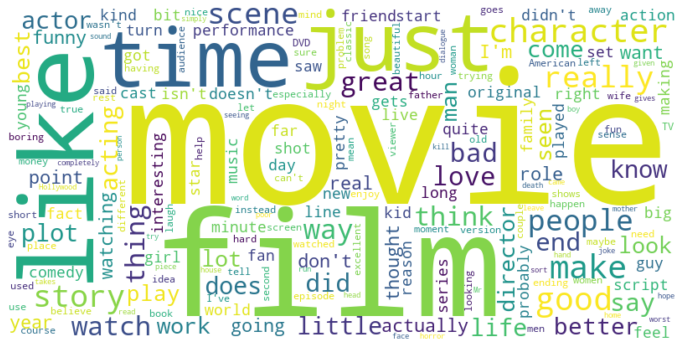

In [ ]:
# Concatenate the text review data
reviews = " ".join(df["text"])

# Create the word cloud image
word_cloud = WordCloud(background_color='white',
                       stopwords=ENGLISH_STOP_WORDS,
                       width=800,
                       height=400)

# Generate the word cloud using the review data
word_cloud.generate(reviews)

# Display the word cloud
plt.rcParams["figure.figsize"] = (12, 8)
plt.imshow(word_cloud, interpolation="bilinear") 
plt.axis("off")
plt.show()


## Pre-processing the review text
To pre-process the text, we will use the term frequency-inverse document frequency, or TfIdf. TfIdf is a way of calculating the importance of words in a collection of different sets of text (or documents).
TfIdf has the advantages of:

- Highlighting words that are common within a document but not across documents.
- Returning low scores for words common across all reviews (e.g., movie in movie reviews).
- Penalizing frequent words so we don't need to worry about stop words as much.

Fortunately, Scikit-Learn has a [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class that can convert text data into a set of TfIdf features.

In [ ]:
# Specify the word pattern
pattern = r"[a-zA-Z]+"

# Build the vectorizer and fit to the text data
vect = TfidfVectorizer(
    token_pattern=pattern, # Define the pattern to extract words
    stop_words=ENGLISH_STOP_WORDS, # Default list of English stop words
    ngram_range=(1, 2),  # Consider uni- and bi-grams
    max_features=500,  # Maximum number of features
)

vect.fit(df["text"])

# Create sparse matrix from the vectorizer
tokenized_features = vect.transform(df["text"])

# Create a DataFrame of the new features
features = pd.DataFrame(data=tokenized_features.toarray(), 
                        columns=vect.get_feature_names_out()
                       )
features


,able,absolutely,act,acting,action,actor,actors,actress,actually,add,...,wouldn t,writer,writing,written,wrong,year,year old,years,yes,young
0,0.000000,0.073909,0.077820,0.140430,0.062353,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.086017,...,0.000000,0.0,0.0,0.158546,0.0,0.0,0.0,0.059755,0.080679,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.109195,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.151444,0.0,0.000000,0.000000,...,0.220499,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.138907,0.000000,0.140286,0.000000,0.000000,0.000000,0.097776,0.0,0.201605,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110813,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.113823,0.000000,0.0
3996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3998,0.000000,0.000000,0.000000,0.169746,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0


Let's add a few more features about the nature of the review, calculating different length metrics for the text (inspired by this [great article](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d)).

In [ ]:
# Generate a number of different length metrics based on the text
df["char_count"] = df["text"].str.count(r"\S")
df["word_count"] = df["text"].str.count(pattern)
df["avg_word_length"] = df["char_count"] / df["word_count"]

# Preview our new columns
df.sample(3)


,text,label,char_count,word_count,avg_word_length
1972,"This film, had it been done properly, has SO m...",0,542,129,4.201550
3046,"I thought this movie was great, not only becau...",1,582,130,4.476923
3767,I am not one of those people who just go onlin...,0,1224,295,4.149153


## Fit a model and evaluate its performance
Finally, we assign our features and target to `X` and `y`, respectively, split our data into train and test subsets, and fit a classification model to the data.

In this case, we use a simple [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and calculate the classification metrics using the test set and our predicted values.

In [ ]:
# Define X and y
X = pd.concat([features, df.loc[:, "char_count":]], axis=1)
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,  
    random_state=42
)

# Train a random forest classifier
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Predict the labels
y_pred = rf.predict(X_test)

# Print classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       523
           1       0.76      0.80      0.78       477

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.78      1000
weighted avg       0.79      0.79      0.79      1000



We can also generate a confusion matrix using [`ConfusionMatrixDisplay.from_estimator()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay#sklearn.metrics.ConfusionMatrixDisplay.from_estimator) to gain additional insights into the performance of our classification. This allows us to see what percentage of predictions were true positives, true negatives, false positives, and false negatives.

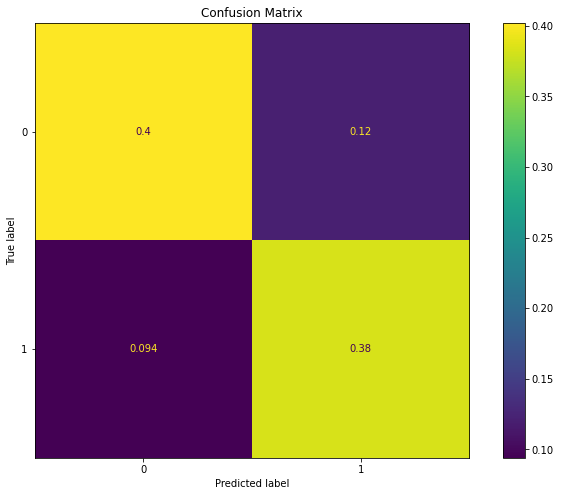

In [ ]:
# Print a confusion matrix for the model
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix")
plt.show()


For one final step, let's look at the feature importances to see which words (or features) were most relevant.

In [ ]:
# Create a DataFrame of the features and their importances
pd.DataFrame({
    "feature": X.columns, 
    "importance": rf.feature_importances_}).sort_values(by="importance", ascending=False)


,feature,importance
27,bad,0.045045
487,worst,0.031163
174,great,0.021562
415,t,0.016111
25,awful,0.015166
...,...,...
420,talent,0.000416
482,words,0.000411
160,game,0.000385
17,aren,0.000374


## Wrapping up
Congratulations! We successfully loaded in some review data, inspected it, performed some simple text-processing, and made predictions.